In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('dataset/data/train/benign',224))
malign_train = np.array(Dataset_loader('dataset/data/train/malignant',224))
benign_test = np.array(Dataset_loader('dataset/data/test/benign',224))
malign_test = np.array(Dataset_loader('dataset/data/test/malignant',224))

100%|██████████| 287/287 [00:00<00:00, 901.97it/s]


In [16]:
# breastCancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [17]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

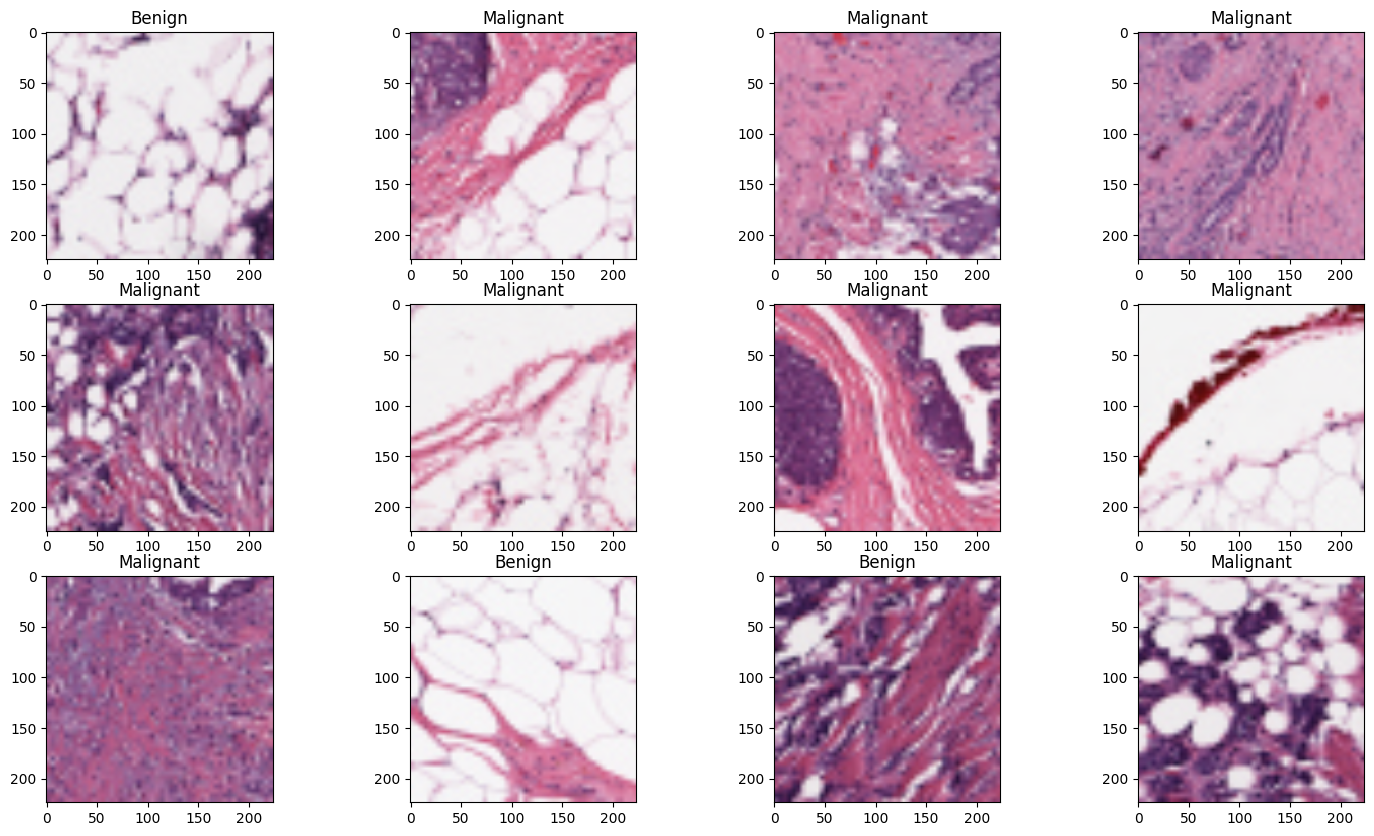

In [18]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [19]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [20]:

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
    return model

In [21]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ ?                      │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [22]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="myapp/model/weights.best.hdf5.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [23]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20


c:\Users\ashik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 398s 5s/step - accuracy: 0.7042 - loss: 0.6114 - val_accuracy: 0.4929 - val_loss: 0.9185 - learning_rate: 1.0000e-04
Epoch 2/20


c:\Users\ashik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
c:\Users\ashik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


 1/52 ━━━━━━━━━━━━━━━━━━━━ 3:58 5s/step - accuracy: 0.6875 - loss: 0.5322

c:\Users\ashik\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - accuracy: 0.6875 - loss: 0.5322 - val_accuracy: 0.4929 - val_loss: 0.9251 - learning_rate: 1.0000e-04
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - accuracy: 0.8285 - loss: 0.4063 - val_accuracy: 0.9005 - val_loss: 0.2924 - learning_rate: 1.0000e-04
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 286ms/step - accuracy: 0.8125 - loss: 0.3845 - val_accuracy: 0.9005 - val_loss: 0.2832 - learning_rate: 1.0000e-04
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - accuracy: 0.8476 - loss: 0.3631 - val_accuracy: 0.8531 - val_loss: 0.3229 - learning_rate: 1.0000e-04
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 275ms/step - accuracy: 0.9375 - loss: 0.2137 - val_accuracy: 0.8483 - val_loss: 0.3262 - learning_rate: 1.0000e-04
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 243s 5s/step - accuracy: 0.8736 - loss: 0.3132 - val_accuracy: 0.9147 - val_loss: 0.2232 - learning_rate: 1.0000e-04
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.8125 - l

In [ ]:
with open('history.json', 'w') as f:
    json.dump((history.history), f)

In [25]:
model.save('C:/Users/ashik/OneDrive/Desktop/PW/.ipynb_checkpoints/bc_detect.h5.keras')

<Axes: >

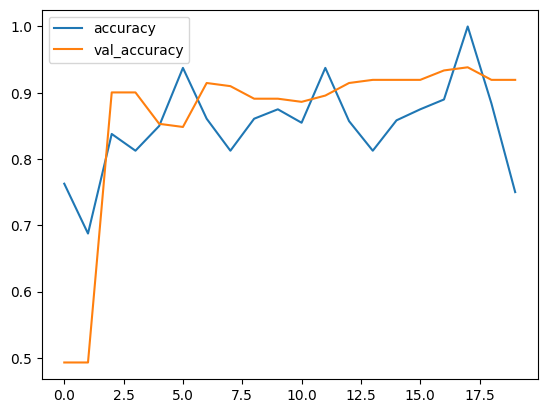

In [26]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<Axes: >

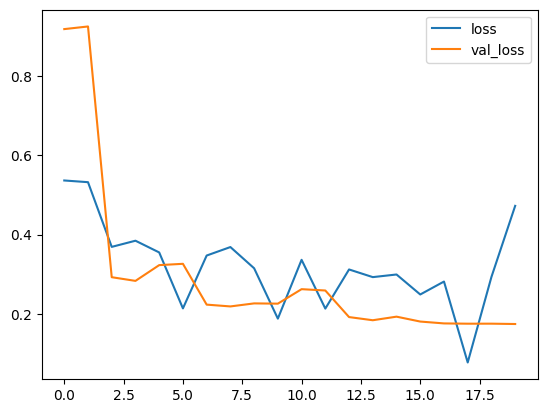

In [27]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [28]:
model.load_weights("C:/Users/ashik/OneDrive/Desktop/PW/.ipynb_checkpoints/bc_detect.h5.keras")

In [29]:
Y_val_pred = model.predict(x_val)

7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step


In [30]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.919431279620853

In [31]:
Y_pred = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step


In [32]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(
        train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
        steps=int(len(X_test) / BATCH_SIZE)
    )
    predictions.append(preds)
    gc.collect()

# Combine predictions (e.g., via averaging for TTA)
Y_pred_tta = np.mean(predictions, axis=0)


  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\ashik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step


 10%|█         | 1/10 [01:03<09:34, 63.80s/it]

35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step


 20%|██        | 2/10 [02:01<08:03, 60.38s/it]

35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step


 30%|███       | 3/10 [02:57<06:49, 58.44s/it]

35/35 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step


 40%|████      | 4/10 [04:06<06:14, 62.36s/it]

35/35 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step


 50%|█████     | 5/10 [05:08<05:11, 62.27s/it]

35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step


 60%|██████    | 6/10 [06:06<04:03, 60.96s/it]

35/35 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step


 70%|███████   | 7/10 [07:10<03:05, 61.81s/it]

35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step


 80%|████████  | 8/10 [08:06<02:00, 60.02s/it]

35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step


 90%|█████████ | 9/10 [09:03<00:59, 59.11s/it]

35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step


100%|██████████| 10/10 [10:01<00:00, 60.13s/it]


Confusion matrix, without normalization
[[263  10]
 [ 64 223]]


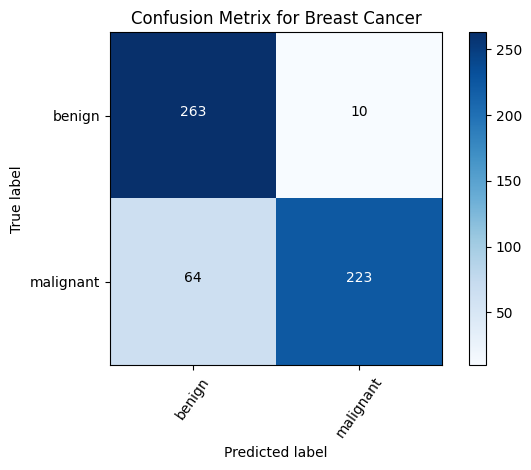

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

Shape of Y_test: (560, 2)
Shape of Y_pred_tta: (560, 2)
Confusion Matrix:
 [[240  33]
 [ 28 259]]
Confusion matrix, without normalization
[[240  33]
 [ 28 259]]


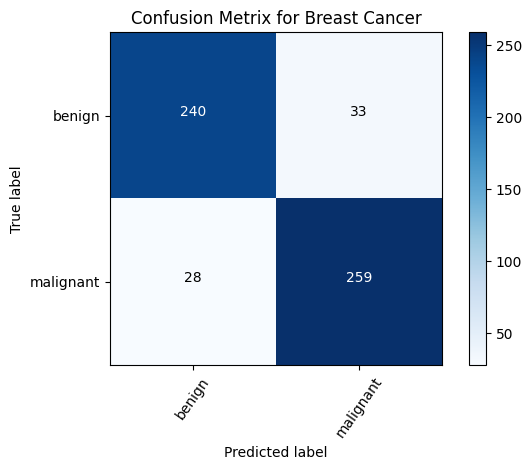

In [34]:
# Debugging shapes
print("Shape of Y_test:", Y_test.shape)
print("Shape of Y_pred_tta:", Y_pred_tta.shape)

# Truncate or pad arrays to match lengths
min_samples = min(len(Y_test), len(Y_pred_tta))
Y_test = Y_test[:min_samples]
Y_pred_tta = Y_pred_tta[:min_samples]

# Compute class labels if inputs are one-hot encoded
if len(Y_test.shape) == 2:
    Y_test_classes = np.argmax(Y_test, axis=1)
    Y_pred_classes = np.argmax(Y_pred_tta, axis=1)
else:
    Y_test_classes = Y_test
    Y_pred_classes = Y_pred_tta

# Compute confusion matrix
cm = confusion_matrix(Y_test_classes, Y_pred_classes)
print("Confusion Matrix:\n", cm)

# cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

# cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

In [35]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.90      0.88      0.89       273\n           1       0.89      0.90      0.89       287\n\n    accuracy                           0.89       560\n   macro avg       0.89      0.89      0.89       560\nweighted avg       0.89      0.89      0.89       560\n'

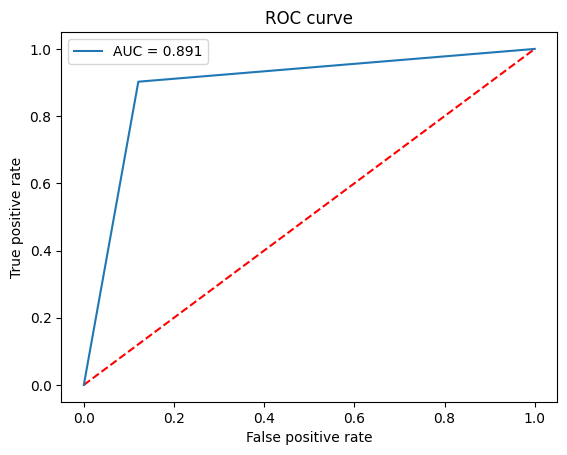

In [36]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

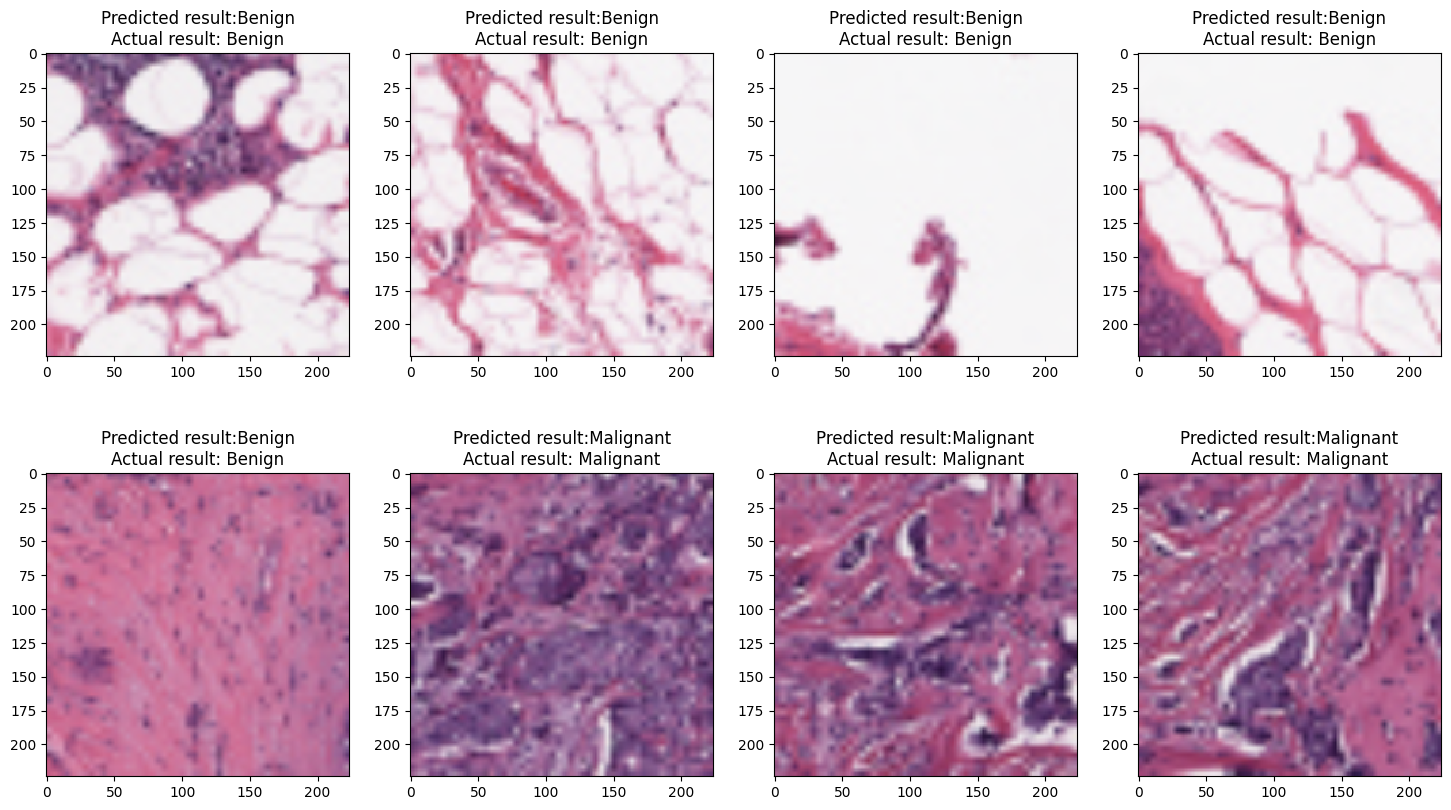

In [37]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

# i=0
# for i in range(len(Y_test)):
#     if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
#         mis_class.append(i)
#     if(len(mis_class)==8):
#         break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()